### FastText sequence embeddings in Deep Learning models
Try FastText embeddings in ConvNet & LSTM models to see how they fare against earlier experiments with word2vec

In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.layers import Bidirectional,LSTM
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

### Read in training data

In [5]:
full_train = pd.read_csv('../train.csv')
full_train.shape

(95851, 8)

In [6]:
labels = np.array(full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']])

In [7]:
comments=full_train['comment_text'].tolist()

In [8]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

### Read in test data

In [9]:
testdat = pd.read_csv('../test.csv')

In [10]:
test_comments0 = testdat['comment_text'].tolist()

In [11]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        for token in test_comments[i]:        
            if token in token_set:
                token_dict[token] += 1
            else:
                token_set.add(token)
                token_dict[token] = 1  

52300 nan


In [12]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq']

In [13]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()

In [15]:
reduced_token_count = token_count[token_count['freq']>=10]
reduced_token_set = set(reduced_token_count['token'])

In [16]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token).to_dict()

In [17]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [29]:
MAX_SEQ_LENGTH=300
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load FastText embeddings

In [19]:
fasttext_model = gensim.models.Word2Vec.load("../wiki_fasttext_embed")

In [21]:
print(len(fasttext_model.wv.vocab))
print(reduced_token_count.shape)

41286
(41286, 3)


In [22]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=150
print((V,EMBEDDING_DIM))

(41287, 150)


In [24]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = fasttext_model.wv[token]
    
embed_matrix.shape    

(41287, 150)

### Split training data into train,valid sets

In [35]:
labels0,tokenized_corpus_padded0 = shuffle(labels,tokenized_corpus_padded)

In [36]:
clean_comment = np.zeros(shape=[labels.shape[0]])
clean_comment[np.max(labels,axis=1)==0] = 1

In [37]:
labels_train,labels_valid, \
seq_train,seq_valid  = \
train_test_split(labels0,tokenized_corpus_padded0,\
                 test_size=0.2,stratify=clean_comment)

## Convolutional model
Same architecture as for w2v experiments

In [30]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=300
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [31]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='sigmoid',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [32]:
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(6, activation="sigmoid")(Conv_dense)

In [33]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 300)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 300, 150)          6193050   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           67264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [38]:
history_CNN = cnn_model.fit(seq_train,labels_train
                           ,epochs=6
                           ,batch_size=16
                           ,validation_data=(seq_valid,labels_valid)
                           ,verbose=1)

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 441s - loss: 0.0755 - acc: 0.9759 - val_loss: 0.0541 - val_acc: 0.9809
Epoch 2/6
76680/76680 [==============================] - 440s - loss: 0.0560 - acc: 0.9805 - val_loss: 0.0517 - val_acc: 0.9819
Epoch 3/6
76680/76680 [==============================] - 441s - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0506 - val_acc: 0.9819
Epoch 4/6
76680/76680 [==============================] - 440s - loss: 0.0492 - acc: 0.9819 - val_loss: 0.0509 - val_acc: 0.9820
Epoch 5/6
76680/76680 [==============================] - 440s - loss: 0.0467 - acc: 0.9826 - val_loss: 0.0497 - val_acc: 0.9816
Epoch 6/6
76680/76680 [==============================] - 442s - loss: 0.0438 - acc: 0.9836 - val_loss: 0.0522 - val_acc: 0.9817


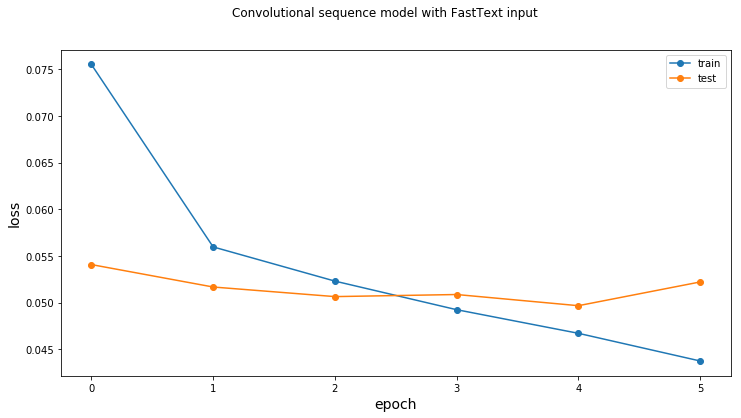

In [39]:
plt.figure(figsize=(12,6))
plt.suptitle("Convolutional sequence model with FastText input")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],'-o',label='train')
plt.plot(history_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

In [40]:
np.min(history_CNN.history['val_loss'])

0.049671591895302444